Making MNIST purely difficult!!
- extend color dim -> various paper type(yellow, ...) + pen type(blue, red, ...)
- 

In [1]:
import torch
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

train_data = torchvision.datasets.MNIST("./", train=True, transform=T.ToTensor(), download=True)
test_data = torchvision.datasets.MNIST("./", train=False, transform=T.ToTensor(), download=True)
data = train_data + test_data
train_data, test_data = train_test_split(data, test_size=1000)

In [2]:
import math
# helpers
topil = T.ToPILImage()

def show(img_tensor, label):
    params = {}
    is_gray = img_tensor.shape[0] == 1 # 1 -> gray / 3 -> rgb
    if is_gray:
        params["cmap"] = "gray"
    pil_img = topil(img_tensor)
    
    plt.imshow(pil_img, **params)
    plt.title(f"label: {label}")

def show_grid(img_tensors, title):
    num_items = len(img_tensors)
    auto_shape = ()
    for i in range(int(math.sqrt(num_items)))[::-1]:
        if num_items % i == 0:
            auto_shape = (i, num_items//i)
            print(i)
            break
    h, w = auto_shape
    fig, ax = plt.subplots(h, w)
    for i in range(h):
        for j in range(w):
            index = i*h+j
            img_tensor = img_tensors[index]
            ax[index].imshow(topil(img_tensor))
    fig.suptitle(title)
    return

In [3]:
sample = train_data[0][0]
label = train_data[0][1]

Text(0.5, 1.0, 'label: 8')

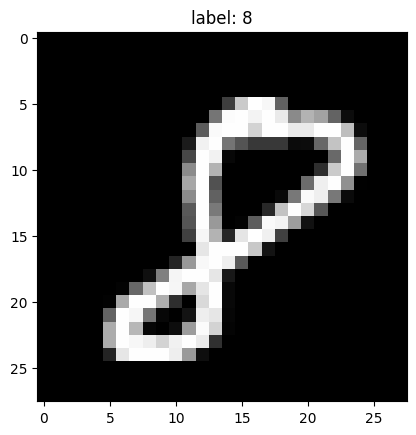

In [4]:
plt.imshow(sample.permute(1, 2, 0).numpy(), cmap="gray")
plt.title(f"label: {label}")

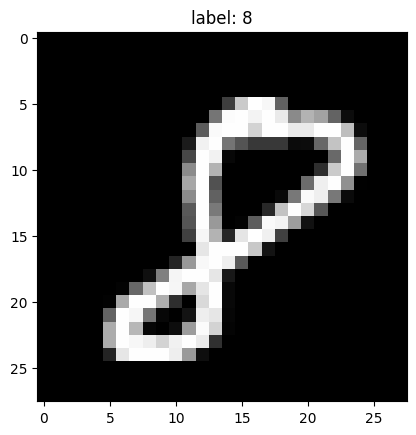

In [5]:
show(sample, label)

In [6]:
# extend color dim
test_sample = sample.expand(3, 28, 28)

In [7]:
from colour import Color
black = Color("black")
colors = list(black.range_to(Color(rgb=(224/255, 220/255, 54/255)),30))

In [8]:
colors[1].rgb

(0.019271424999537722, 0.01835352707112471, 0.018321543222233744)

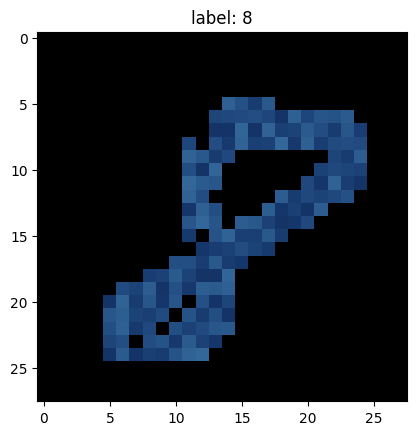

In [9]:
import torch
from colour import Color
import random

threshold = 0.001
mask = test_sample > threshold
random_quant = torch.rand((28, 28)).expand(3, 28, 28)  # Noise tensor matching mask shape
p = 0.03
mask[random_quant < p] = 0  # Randomly drop p% of the mask to add noise

# Define pen gradient (red ballpoint-like)
pen_start = Color(rgb=(20/255, 51/255, 102/255))
pen_end = Color(rgb=(51/255, 102/255, 153/255))
pen_colors = list(pen_start.range_to(pen_end, 28))  # 28 steps for 28x28 image

pen_gradient = torch.zeros(3, 28, 28)
for i in range(28):
    for j in range(28):
        pen_gradient[:, i, j] = torch.tensor(random.sample(pen_colors, k=1)[0].rgb)

color_pen_sample = torch.where(~mask, torch.zeros((3, 28, 28)), pen_gradient)
# print(pen_gradient)
show(color_pen_sample, label)

In [10]:
import glob

imgs = [Image.open(i).convert('RGB') for i in glob.glob("./papers/*")]
imgs = [T.ToTensor()(img) for img in imgs]

In [11]:
for img in imgs:
    print(img.shape)

torch.Size([3, 533, 800])
torch.Size([3, 1024, 998])
torch.Size([3, 600, 600])
torch.Size([3, 1021, 800])
torch.Size([3, 183, 275])


In [12]:
# 28 -> 36
target_dim = 64
half_target_dim = target_dim // 2

cropped_imgs = []
for img in imgs:
    _, h, w = img.shape
    coh, cow = h//2, w//2
    cropped = img[:, coh-half_target_dim:coh+half_target_dim, cow-half_target_dim:cow+half_target_dim]
    cropped_imgs.append(cropped)

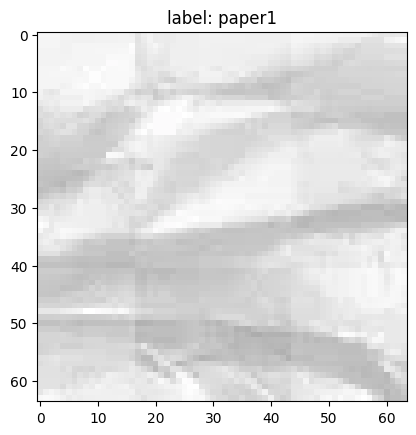

In [13]:
show(cropped_imgs[0], "paper1")

1


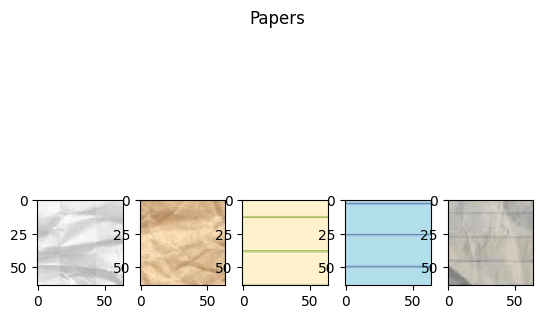

In [14]:
show_grid(cropped_imgs, "Papers")

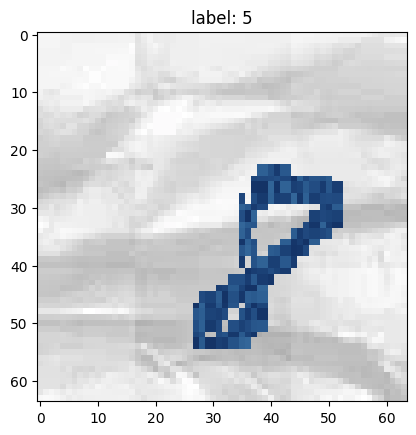

In [15]:
# transformed_sample = torch.where(~mask, pen_gradient)
results = []

for i, bg in enumerate(cropped_imgs):
# bg = cropped_imgs[0]
    empty = torch.zeros_like(bg)
    h, w = random.randint(30, 50), random.randint(30, 50)
    resized = T.Resize((h, w), T.InterpolationMode.NEAREST)(color_pen_sample)
    start_h, start_w = random.randint(0, target_dim-h), random.randint(0, target_dim-w)
    empty[:, start_h:start_h+h, start_w:start_w+w] = resized
    result = torch.where(empty<threshold, bg, empty)
    results.append(result)
# show_grid(results, "")
show(results[0], "5")

In [16]:
pen_gradients = []
for i in range(3):
    data = ((20/255, 51/255), (51/255, 102/255), (102/255, 153/255))
    pen_start = Color(rgb=(data[i][0], data[(i+1)%3][0], data[(i+2)%3][0]))
    pen_end = Color(rgb=(data[i][1], data[(i+1)%3][1], data[(i+2)%3][1]))
    pen_colors = list(pen_start.range_to(pen_end, 30))
    pen_gradient = torch.zeros(3, 28, 28)
    for i in range(28):
        for j in range(28):
            pen_gradient[:, i, j] = torch.tensor(random.sample(pen_colors, k=1)[0].rgb)
    pen_gradients.append(pen_gradient)
    
def make_it_difficult(tensor_img):
    if tensor_img.shape[0] == 1:
        tensor_img = tensor_img.expand(3, 28, 28)
    threshold = 0.001
    mask = tensor_img > threshold
    # random_quant = torch.rand((28, 28)).expand(3, 28, 28)  # Noise tensor matching mask shape
    # p = 0.01
    # mask[random_quant < p] = 0  # Randomly drop p% of the mask to add noise
    
    color_pen_sample = torch.where(~mask, torch.zeros((3, 28, 28)), random.choice(pen_gradients))
    
    results = []
    cropped_img = random.choice(cropped_imgs)
    empty = torch.zeros_like(bg)
    h = random.randint(30, 50)
    w = random.randint(min(int(h/1.2), 30), max(int(h*1.2), 50)) # prevent too much distortion
    resized = T.Resize((h, w), T.InterpolationMode.NEAREST)(color_pen_sample)
    start_h, start_w = random.randint(0, target_dim-h), random.randint(0, target_dim-w)
    empty[:, start_h:start_h+h, start_w:start_w+w] = resized
    result = torch.where(empty<threshold, bg, empty)

    return result

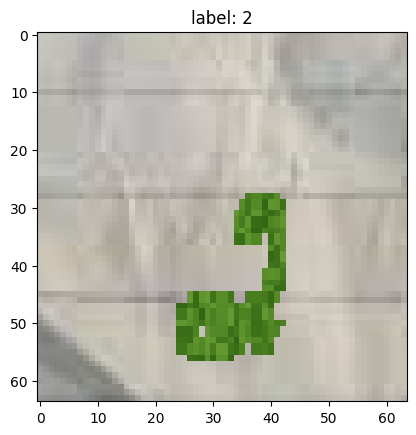

In [17]:
i = 10001
show(make_it_difficult(train_data[i][0]), train_data[i][1])

In [18]:
transformed_train_data = [(make_it_difficult(x), y)for (x, y) in train_data]

In [19]:
transformed_test_data = [(make_it_difficult(x), y)for (x, y) in test_data]

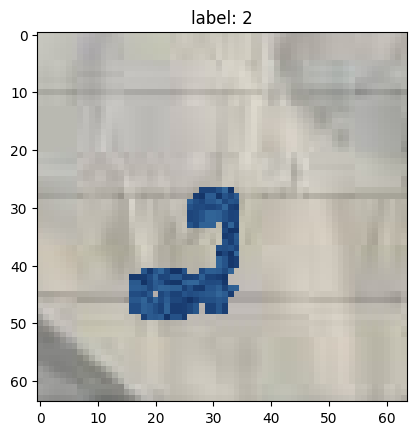

In [20]:
show(transformed_train_data[i][0], transformed_train_data[i][1])

In [21]:
import torch
from datasets import Dataset, DatasetDict
import numpy as np

# Dummy data
image_tensors = torch.randn(100, 3, 64, 64)  # 100 RGB images
labels = np.random.randint(0, 10, size=(100,))

train_data_dict = {"image": [], "label": []}
for (x, y) in transformed_train_data:
    train_data_dict["image"].append(x.numpy())
    train_data_dict["label"].append(y)

# Convert to Python list (to make it JSON serializable)
dataset = Dataset.from_dict(train_data_dict)

In [22]:
from datasets import Dataset, DatasetDict
test_data_dict = {"image":[], "label": []}
for (x, y) in transformed_test_data:
    test_data_dict["image"].append(x.numpy())
    test_data_dict["label"].append(-1)
test_dataset = Dataset.from_dict(test_data_dict)

In [23]:
labels = []
for (_, y) in transformed_test_data:
    labels.append(f"{y}")
with open("sol.txt", "w") as f:
    f.write("\n".join(labels))

In [24]:
print(test_dataset)
print(dataset)

Dataset({
    features: ['image', 'label'],
    num_rows: 1000
})
Dataset({
    features: ['image', 'label'],
    num_rows: 69000
})


In [25]:
torch.tensor(dataset[0]["image"])

tensor([[[0.7804, 0.7765, 0.7725,  ..., 0.7529, 0.7333, 0.7020],
         [0.7765, 0.7725, 0.7686,  ..., 0.7490, 0.7216, 0.6980],
         [0.7765, 0.7686, 0.7647,  ..., 0.7294, 0.7020, 0.6980],
         ...,
         [0.6392, 0.6235, 0.6118,  ..., 0.7922, 0.7569, 0.7804],
         [0.6275, 0.6157, 0.6039,  ..., 0.7725, 0.7451, 0.7569],
         [0.5804, 0.5686, 0.5569,  ..., 0.7490, 0.7294, 0.6902]],

        [[0.7804, 0.7765, 0.7725,  ..., 0.7412, 0.7216, 0.6902],
         [0.7765, 0.7725, 0.7686,  ..., 0.7294, 0.7020, 0.6784],
         [0.7765, 0.7686, 0.7647,  ..., 0.7098, 0.6824, 0.6784],
         ...,
         [0.6392, 0.6235, 0.6118,  ..., 0.7765, 0.7412, 0.7647],
         [0.6275, 0.6157, 0.6039,  ..., 0.7569, 0.7294, 0.7412],
         [0.5804, 0.5686, 0.5569,  ..., 0.7333, 0.7137, 0.6745]],

        [[0.7490, 0.7451, 0.7412,  ..., 0.7216, 0.7020, 0.6706],
         [0.7451, 0.7412, 0.7373,  ..., 0.7059, 0.6784, 0.6549],
         [0.7451, 0.7373, 0.7333,  ..., 0.6863, 0.6588, 0.

In [26]:
dataset_dict = DatasetDict({
    "train": dataset,
    "test": test_dataset
})
dataset_dict.push_to_hub("yoonhero/difficult_mnist")


Uploading the dataset shards:   0%|          | 0/7 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/yoonhero/difficult_mnist/commit/fe57ead169416d2157e1f71526da59b62a8c1dae', commit_message='Upload dataset', commit_description='', oid='fe57ead169416d2157e1f71526da59b62a8c1dae', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/yoonhero/difficult_mnist', endpoint='https://huggingface.co', repo_type='dataset', repo_id='yoonhero/difficult_mnist'), pr_revision=None, pr_num=None)